using vader, roberta pretrained model and hugging face pipeline

Import data and NLTK basics

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import random
import nltk
nltk.download('punkt')  # Ensure the standard punkt tokenizer is installed
nltk.download('averaged_perceptron_tagger')  # Sometimes required for tokenization
nltk.download('wordnet')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('sentiment_train.csv')
print(df.shape)
print(df.head(500))

(45615, 2)
                                                  text  label
0    "QT @user In the original draft of the 7th boo...      2
1    "Ben Smith / Smith (concussion) remains out of...      1
2    Sorry bout the stream last night I crashed out...      1
3    Chase Headley's RBI double in the 8th inning o...      1
4    @user Alciato: Bee will invest 150 million in ...      2
..                                                 ...    ...
495  "Your 3rd gen. iPad with Retina display is wor...      1
496  "From the Twitter just now from RNDM: """"RNDM...      1
497  @user @user You are a Patriot! Such compassion...      2
498  "Watching Les Mis 25th Anniversary concert. Ho...      0
499  I\u2019d want Mannone\u002cJenks/sagna\u002cpe...      1

[500 rows x 2 columns]


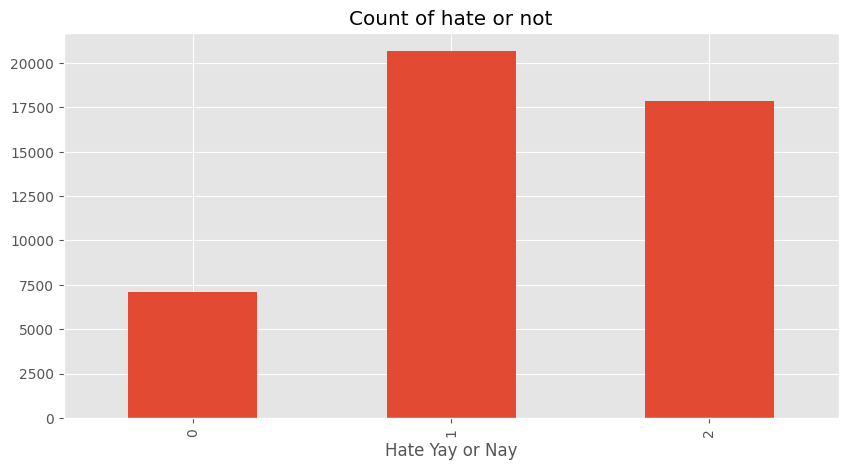

In [3]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of hate or not',
          figsize=(10, 5))
ax.set_xlabel('Hate Yay or Nay')
plt.show()

In [4]:
example = df['text'][random.randint(0, 500)]
print(example)

I hope Bernie Sanders is a sun and the other two are shooting stars or black holes.


In [5]:
tokens = nltk.word_tokenize(example)
print(tokens[:10])


['I', 'hope', 'Bernie', 'Sanders', 'is', 'a', 'sun', 'and', 'the', 'other']


In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('hope', 'VBP'),
 ('Bernie', 'NNP'),
 ('Sanders', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('sun', 'NN'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('other', 'JJ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  hope/VBP
  (PERSON Bernie/NNP Sanders/NNP)
  is/VBZ
  a/DT
  sun/NN
  and/CC
  the/DT
  other/JJ
  two/CD
  are/VBP
  shooting/VBG
  stars/NNS
  or/CC
  black/JJ
  holes/NNS
  ./.)


Pre Processing


In [8]:
import string

import re

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import contractions


In [9]:
def remove_hyperlinks_marks_styles(text):
    new_text = re.sub(r'^RT[\s]', '', text)
    new_text = re.sub(r'@\S+', '', new_text)
    new_text = re.sub(r'https?:\/\/.*[\r\n]*','', new_text)
    new_text = re.sub(r'#', '', new_text)

    return new_text
    

In [10]:
def tokenize_text(text):

    text_tokens = nltk.word_tokenize(text)

    return text_tokens


In [11]:
nltk.download('stopwords')

stopwords_english = stopwords.words('english')

punctuations = string.punctuation

def remove_punctuations_stopwords(text_tokens):

    text_clean = []

    for word in text_tokens:
        if (word not in stopwords_english and word not in punctuations):
            text_clean.append(word)

    return text_clean


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def expand_contractions_in_text(text):
    return contractions.fix(text)

In [13]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif nltk_tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif nltk_tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

In [14]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_tokens):
    pos_tags = pos_tag(text_tokens)  # POS tagging
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]


In [15]:
def preprocess_text(text):
    text = remove_hyperlinks_marks_styles(text)  # Remove unnecessary elements
    #text = expand_contractions_in_text(text)
    tokens = tokenize_text(text)  # Tokenize
    tokens = remove_punctuations_stopwords(tokens)  # Remove stopwords & punctuation
    tokens = lemmatize_text(tokens)  # Lemmatize with POS tagging
    return " ".join(tokens)  # Convert back to string if needed

preprocessing example

In [16]:
text = df['text'][random.randint(0, 500)]
processed_text = preprocess_text(text)

print("Original:", text)
print("Processed:", processed_text)

Original: Amy Schumer sat down with The Hollywood Reporter and opened up about the sexist remarks and unnecessary criticism she's faced since
Processed: Amy Schumer sit The Hollywood Reporter open sexist remark unnecessary criticism 's face since


preprocessing all datasets

In [17]:
train_data = pd.read_csv('sentiment_train.csv')
val_data = pd.read_csv('sentiment_validation.csv')
test_data = pd.read_csv('sentiment_test.csv')


X_train, y_train = train_data['text'], train_data['label']
X_val, y_val = val_data['text'], val_data['label']
X_test, y_test = test_data['text'], test_data['label']

In [18]:
# Ensure the text column is a string and handle NaNs
X_train = X_train.astype(str).fillna('')
X_val = X_val.astype(str).fillna('')
X_test = X_test.astype(str).fillna('')

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)


In [19]:
print(X_train)

0        `` QT In original draft 7th book Remus Lupin s...
1        `` Ben Smith Smith concussion remain lineup Th...
2        Sorry bout stream last night I crash tonight s...
3        Chase Headley 's RBI double 8th inning David P...
4        Alciato Bee invest 150 million January another...
                               ...                        
45610    '' '' So amazing beautiful Lady Gaga show AC t...
45611    9 September arrive mean Apple 's new iPhone ho...
45612    Leeds 1-1 Sheff Wed. Giuseppe Bellusci secure ...
45613    I 'm hilton head till 8th lol go Jason aldean ...
45614    WASHINGTON Reuters U.S. Vice President Joe Bid...
Name: text, Length: 45615, dtype: object


Naive Bayes Model

Converting text into numerical features using TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.8) 


In [21]:
# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation and test data
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve

converting labels to negative or non negative

In [23]:
y_train_binary = y_train.apply(lambda x: 1 if x == 0 else 0)  # 0 = negative (target), 1 & 2 = non-negative
y_val_binary = y_val.apply(lambda x: 1 if x == 0 else 0)
y_test_binary = y_test.apply(lambda x: 1 if x == 0 else 0)


In [24]:
model = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5,2.0, 5.0, 7.5, 10],  # Smoothing parameter
    'fit_prior': [True, False]      # Whether to learn class prior probabilities
}

# Track the best model and score
best_score = 0
best_params = {}


In [25]:
for alpha in param_grid['alpha']:
    for fit_prior in param_grid['fit_prior']:
        # Set model parameters
        model.set_params(alpha=alpha, fit_prior=fit_prior)
        
        # Train on the training set
        model.fit(X_train_tfidf, y_train_binary)
        
        # Evaluate on the validation set
        val_predictions = model.predict(X_val_tfidf)
        val_score = accuracy_score(y_val_binary, val_predictions)
        
        # Update best model if needed
        if val_score > best_score:
            best_score = val_score
            best_params = {'alpha': alpha, 'fit_prior': fit_prior}

print(f"Best Validation Accuracy: {best_score}")
print(f"Best Hyperparameters: {best_params}")

Best Validation Accuracy: 0.8595
Best Hyperparameters: {'alpha': 0.1, 'fit_prior': True}


In [26]:
# Evaluate on Test Set
y_test_pred = model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test_binary, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_binary, y_test_pred))

cm = confusion_matrix(y_test_binary, y_test_pred)
print("Confusion Matrix:\n", cm)


f1 = f1_score(y_test_binary, y_test_pred)
print(f"F1 Score: {f1}")


Test Accuracy: 0.6768967762943666
Test Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.99      0.81      8312
           1       0.51      0.03      0.06      3972

    accuracy                           0.68     12284
   macro avg       0.59      0.51      0.43     12284
weighted avg       0.62      0.68      0.56     12284

Confusion Matrix:
 [[8199  113]
 [3856  116]]
F1 Score: 0.055224946441323496


Neural Network Model


preprocessing

In [27]:

def nn_preprocess_text(text, remove_stopwords=True):
    # Lowercase the text
    text = text.lower()
    
    # Remove hyperlinks etc.

    text = remove_hyperlinks_marks_styles(text)

    #text = expand_contractions_in_text(text)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    
    #Remove stopwords
    if remove_stopwords:
        text = ' '.join(word for word in text.split() if word not in stopwords_english)
    
    return text

In [28]:
text = df['text'][random.randint(0, 500)]
processed_text = nn_preprocess_text(text)

print("Original:", text)
print("Processed:", processed_text)

Original: just sat in on Bruno Mars interviews
Processed: sat bruno mar interview


inputs

In [29]:
import tensorflow as tf

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier


In [31]:
from tensorflow.keras import backend as K

K.clear_session()


In [32]:
nn_train_data = pd.read_csv('sentiment_train.csv')
nn_val_data = pd.read_csv('sentiment_validation.csv')
nn_test_data = pd.read_csv('sentiment_test.csv')


nn_X_train, nn_y_train = nn_train_data['text'], nn_train_data['label']
nn_X_val, nn_y_val = nn_val_data['text'], nn_val_data['label']
nn_X_test, nn_y_test = nn_test_data['text'], nn_test_data['label']

In [33]:
# Ensure the text column is a string and handle NaNs
nn_X_train = nn_X_train.astype(str).fillna('')
nn_X_val = nn_X_val.astype(str).fillna('')
nn_X_test = nn_X_test.astype(str).fillna('')

nn_X_train = nn_X_train.apply(nn_preprocess_text)
nn_X_val = nn_X_val.apply(nn_preprocess_text)
nn_X_test = nn_X_test.apply(nn_preprocess_text)

In [1]:
print(nn_X_train)

NameError: name 'nn_X_train' is not defined

In [35]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(nn_X_train)

nn_X_train_seq = tokenizer.texts_to_sequences(nn_X_train)
nn_X_val_seq = tokenizer.texts_to_sequences(nn_X_val)
nn_X_test_seq = tokenizer.texts_to_sequences(nn_X_test)

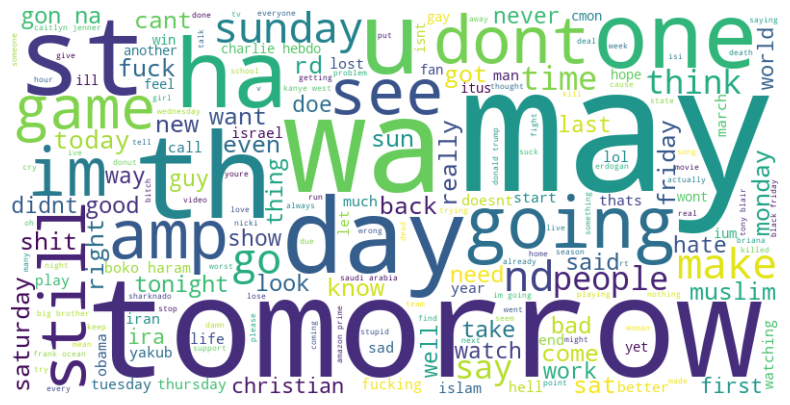

In [36]:
# Filter toxic comments (assuming label 0 indicates toxic comments)
toxic_comments = nn_X_train[nn_y_train == 0]

# Combine all toxic comments into a single string
text_for_wordcloud = ' '.join(toxic_comments)

# Remove stopwords using nltk
stop_words = set(stopwords.words('english'))

# Tokenize and filter out stopwords
tokens = word_tokenize(text_for_wordcloud.lower())  # Tokenize and lowercase
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

# Create the word cloud
cleaned_text = ' '.join(filtered_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [37]:
# Padding sequences
max_sequence_length = 100

nn_X_train_padded = pad_sequences(nn_X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
nn_X_val_padded = pad_sequences(nn_X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
nn_X_test_padded = pad_sequences(nn_X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')


converting labels to negative or non negative

In [38]:
nn_y_train_binary = nn_y_train.apply(lambda x: 1 if x == 0 else 0)  # 0 = negative (target), 1 & 2 = non-negative
nn_y_val_binary = nn_y_val.apply(lambda x: 1 if x == 0 else 0)
nn_y_test_binary = nn_y_test.apply(lambda x: 1 if x == 0 else 0)

In [39]:
print(type(nn_X_train_padded), nn_X_train_padded.shape)
print(type(nn_y_train_binary), nn_y_train_binary.shape)


<class 'numpy.ndarray'> (45615, 100)
<class 'pandas.core.series.Series'> (45615,)


In [40]:
nn_X_train_padded = np.array(nn_X_train_padded)
nn_y_train_binary = np.array(nn_y_train_binary)

nn_X_val_padded = np.array(nn_X_val_padded)
nn_y_val_binary = np.array(nn_y_val_binary)

In [41]:
print(type(nn_X_train_padded), nn_X_train_padded.shape)
print(type(nn_y_train_binary), nn_y_train_binary.shape)


<class 'numpy.ndarray'> (45615, 100)
<class 'numpy.ndarray'> (45615,)


In [42]:
nn_X_test_padded


array([[2962,  646,  641, ...,    0,    0,    0],
       [ 213,  481, 8162, ...,    0,    0,    0],
       [ 151,   93,   37, ...,    0,    0,    0],
       ...,
       [1779,  295, 5816, ...,    0,    0,    0],
       [ 412, 2152,  640, ...,    0,    0,    0],
       [ 778,   91, 5332, ...,    0,    0,    0]], dtype=int32)

In [43]:
def create_grid_model(lstm_units=64, dropout_rate=0.3, learning_rate=0.0001):
    inputs = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim=10000, output_dim=100, trainable = True)(inputs)  # Removed input_length
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units // 2)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

#model for conducting grid search

In [44]:
model = create_grid_model()
model.summary()  # Should show all layers, especially the output layer.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,689 (4.02 MB)

 Trainable params: 1,054,689 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
grid_model = KerasClassifier(model=create_grid_model, verbose=1)


In [46]:
param_grid = {
    'model__lstm_units': [32, 64, 128],  
    'model__dropout_rate': [0.2, 0.3, 0.4],  
    'model__learning_rate': [0.001, 0.0005], 
    'batch_size': [16, 32], 
    'epochs': [5, 10]  
}


In [48]:
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=3, verbose=3, n_jobs=-1)
grid_result = grid.fit(nn_X_val_padded, nn_y_val_binary)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


KeyboardInterrupt: 

In [ ]:
print(f"Best Accuracy: {grid_result.best_score_}")
print(f"Best Parameters: {grid_result.best_params_}")


Best Accuracy: 0.8439999219609415
Best Parameters: {'batch_size': 16, 'epochs': 5, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.001, 'model__lstm_units': 32}


In [49]:
# Build LSTM model

def create_model(lstm_units=32, dropout_rate=0.2, learning_rate=0.01):
    inputs = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim=10000, output_dim=100, trainable=True)(inputs)  # Embedding layer
    x = LSTM(lstm_units, return_sequences=True)(x)  # LSTM with return_sequences=True
    x = Dropout(dropout_rate)(x)
    x = GlobalMaxPooling1D()(x)  # Reduces sequence to a single vector
    outputs = Dense(1, activation='sigmoid')(x)  # Single output for binary classification

    model = Model(inputs, outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 32)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,057 (3.88 MB)

 Trainable params: 1,017,057 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = create_model().fit(nn_X_train_padded, nn_y_train_binary,
                          validation_data=(nn_X_val_padded, nn_y_val_binary),
                          epochs=5,
                          batch_size=16,
                          verbose=1)

Epoch 1/5
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 151s 52ms/step - accuracy: 0.8450 - loss: 0.3860 - val_accuracy: 0.8540 - val_loss: 0.3503
Epoch 2/5
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.8755 - loss: 0.3026 - val_accuracy: 0.8640 - val_loss: 0.3318
Epoch 3/5
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.8795 - loss: 0.2873 - val_accuracy: 0.8605 - val_loss: 0.3281
Epoch 4/5
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 116s 41ms/step - accuracy: 0.8887 - loss: 0.2680 - val_accuracy: 0.8590 - val_loss: 0.3326
Epoch 5/5
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 160s 56ms/step - accuracy: 0.8918 - loss: 0.2610 - val_accuracy: 0.8640 - val_loss: 0.3336


In [51]:
'''
best_params = grid_result.best_params_

final_model = create_model(
    lstm_units=best_params['model__lstm_units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

history = final_model.fit(nn_X_train_padded, nn_y_train_binary,
                          validation_data=(nn_X_val_padded, nn_y_val_binary),
                          epochs=best_params['epochs'],
                          batch_size=best_params['batch_size'],
                          #callbacks=callbacks,
                          verbose=1)
'''

"\nbest_params = grid_result.best_params_\n\nfinal_model = create_model(\n    lstm_units=best_params['model__lstm_units'],\n    dropout_rate=best_params['model__dropout_rate'],\n    learning_rate=best_params['model__learning_rate']\n)\n\nhistory = final_model.fit(nn_X_train_padded, nn_y_train_binary,\n                          validation_data=(nn_X_val_padded, nn_y_val_binary),\n                          epochs=best_params['epochs'],\n                          batch_size=best_params['batch_size'],\n                          #callbacks=callbacks,\n                          verbose=1)\n"

In [52]:
# Train model
#history = model.fit(nn_X_train_padded, nn_y_train_binary, validation_data=(nn_X_val_padded, nn_y_val_binary), epochs=10, batch_size=32, callbacks=callbacks, verbose=1)


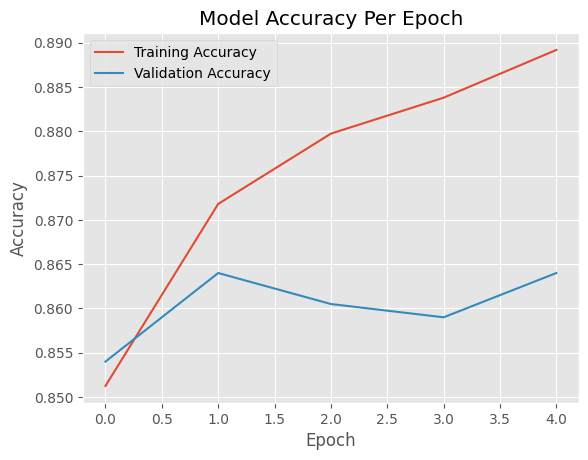

In [53]:
#plot accuracy per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Per Epoch')
plt.legend()
plt.show()

In [54]:
# Evaluate model
nn_y_pred = (create_model().predict(nn_X_test_padded) > 0.35).astype('int32')
print(confusion_matrix(nn_y_test_binary, nn_y_pred))
print('Accuracy:', accuracy_score(nn_y_test_binary, nn_y_pred))

nn_f1 = f1_score(nn_y_test_binary, nn_y_pred)
print(f"F1 Score: {nn_f1}")

384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
[[   0 8312]
 [   0 3972]]
Accuracy: 0.32334744382937153
F1 Score: 0.48868110236220474


In [55]:
np.set_printoptions(threshold=np.inf)  # Disable truncation
print(nn_y_pred)
print(create_model().predict(nn_X_test_padded))

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


In [56]:
#result = 10 / 0
#print(result)

Bert Transformer

imports

In [57]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset



C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
bert_train_data = pd.read_csv('sentiment_train.csv')
bert_val_data = pd.read_csv('sentiment_validation.csv')
bert_test_data = pd.read_csv('sentiment_test.csv')


In [ ]:
bert_train_data['label'] = bert_train_data['label'].apply(lambda x: 1 if x != 0 else 0)
bert_val_data['label'] = bert_val_data['label'].apply(lambda x: 1 if x != 0 else 0)
bert_test_data['label'] = bert_test_data['label'].apply(lambda x: 1 if x != 0 else 0)

In [ ]:
bert_train_data.head(100)

,text,label
0,"""QT @user In the original draft of the 7th boo...",1
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,1
...,...,...
95,@user I\u2019m sick with something ill be at s...,0
96,"""There's something about Friday Night Lights, ...",1
97,Googled the snake I stepped over on the trail ...,1
98,"@user Also, his anger against Hindus are justi...",0


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
bert_train_data = Dataset.from_pandas(bert_train_data)
bert_val_data = Dataset.from_pandas(bert_val_data)
bert_test_data = Dataset.from_pandas(bert_test_data)


In [ ]:
bert_train_data = bert_train_data.map(tokenize_function, batched=True)
bert_val_data = bert_val_data.map(tokenize_function, batched=True)
bert_test_data = bert_test_data.map(tokenize_function, batched=True)

Map: 100%|██████████| 12284/12284 [00:06<00:00, 1872.71 examples/s]


In [ ]:
bert_train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
bert_val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
bert_test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # training epochs
    per_device_train_batch_size=16,   # batch size for training
    per_device_eval_batch_size=16,    # batch size for evaluation
    warmup_steps=500,                # warmup steps for learning rate scheduler
    weight_decay=0.01,               # weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
type(bert_test_data)

datasets.arrow_dataset.Dataset

In [ ]:
num_samples_to_take = 8600
ds = bert_train_data
ds = ds.select(range(num_samples_to_take))

In [ ]:
trainer = Trainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments
    train_dataset=ds,            # training dataset
    eval_dataset=bert_val_data,               # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.predictions.argmax(axis=1), p.label_ids)
    }
)

C:\Users\RajBu\AppData\Local\Temp\ipykernel_38008\819274716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
10,0.891900
20,0.869000
30,0.763500
40,0.648400
50,0.581000
60,0.543400
70,0.494700
80,0.359000
90,0.455700
100,0.474100


TrainOutput(global_step=538, training_loss=0.387295915291655, metrics={'train_runtime': 3279.1626, 'train_samples_per_second': 2.623, 'train_steps_per_second': 0.164, 'total_flos': 565688769024000.0, 'train_loss': 0.387295915291655, 'epoch': 1.0})

In [ ]:
results = trainer.evaluate()
print(f"Results: {results}")

Results: {'eval_loss': 0.3019122779369354, 'eval_accuracy': 0.854, 'eval_runtime': 239.9593, 'eval_samples_per_second': 8.335, 'eval_steps_per_second': 0.521, 'epoch': 1.0}


In [ ]:
predictions, labels, _ = trainer.predict(bert_test_data)
predictions = predictions.argmax(axis=1)

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69      3972
           1       0.86      0.82      0.84      8312

    accuracy                           0.79     12284
   macro avg       0.76      0.77      0.76     12284
weighted avg       0.80      0.79      0.79     12284

